# Retrieval across datasets

We start by loading two datasets. Both datasets are of sea turtles. But the first dataset `d1` depicts loggerhead turtles, the second dataset `d2` depict green turtles.

In [1]:
import sys
sys.path.append('..')

from wildlife_datasets import analysis, datasets, loader, splits

root_dataset = '/mnt/data/turtles/datasets/datasets'
root_dataframe = '/mnt/data/turtles/datasets/dataframes'

d1 = loader.load_dataset(datasets.SeaTurtleIDHeads, root_dataset, root_dataframe)
d2 = loader.load_dataset(datasets.ZindiTurtleRecall, root_dataset, root_dataframe)

We modify the datasets by removing irrelevant information (columns) and unknown individuals (rows). Then we concatenate the two dataset into one `df`. We create one training set and two testing sets. The training set is a subset of loggerhead turtles. The first training set is a subset of the loggerhead turtles, while the second training set is a subset of the green turtles. The training and testing set contain no joint individual. Therefore, the method needs to learn some representation on the training set and apply in to completely new turtles on the testing set.

In [2]:
import os
import pandas as pd

def extract_dataframe(d, discard_unknown=True, index_start=None):
    df = pd.DataFrame(d.df, columns=['id', 'identity', 'path'])
    df['path'] = df['path'].apply(lambda x: os.path.join(root_dataset, d.__class__.__name__, x))
    if discard_unknown:
        df = df[df['identity'] != 'unknown']
    if index_start is not None:
        df.index = list(range(index_start, index_start+len(df)))
    return df

def check_empty_intersection(df1, df2, col):
    val1 = set(df1[col].unique())
    val2 = set(df2[col].unique())
    if len(val1.intersection(val2)):
        raise Exception('Intersection is not empty')

df1 = extract_dataframe(d1, index_start=0)
df2 = extract_dataframe(d2, index_start=len(df1))
check_empty_intersection(df1, df2, 'id')
check_empty_intersection(df1, df2, 'identity')

df = pd.concat((df1, df2))
splitter = splits.DisjointSetSplit(df1)
idx_train, idx_test1 = splitter.split(0.5)
idx_test2 = df2.index

We see the differences between training and testing set, we plot some subset of each set.

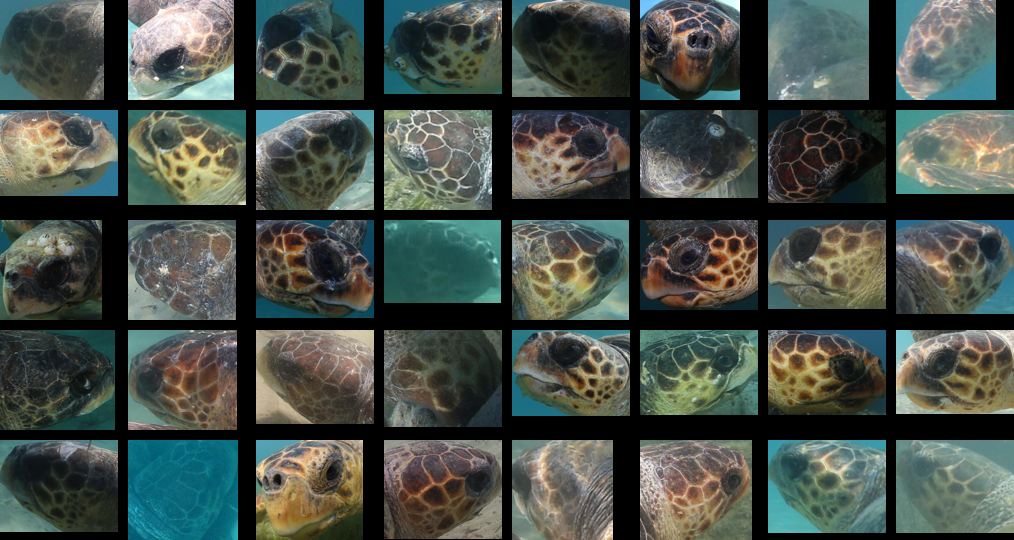

In [3]:
analysis.plot_grid(df.loc[idx_train], '')

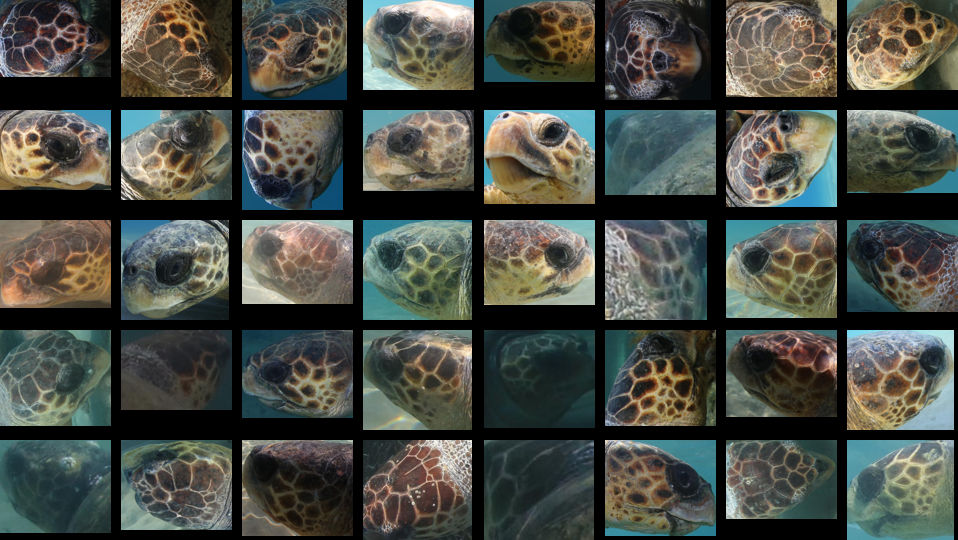

In [4]:
analysis.plot_grid(df.loc[idx_test1], '')

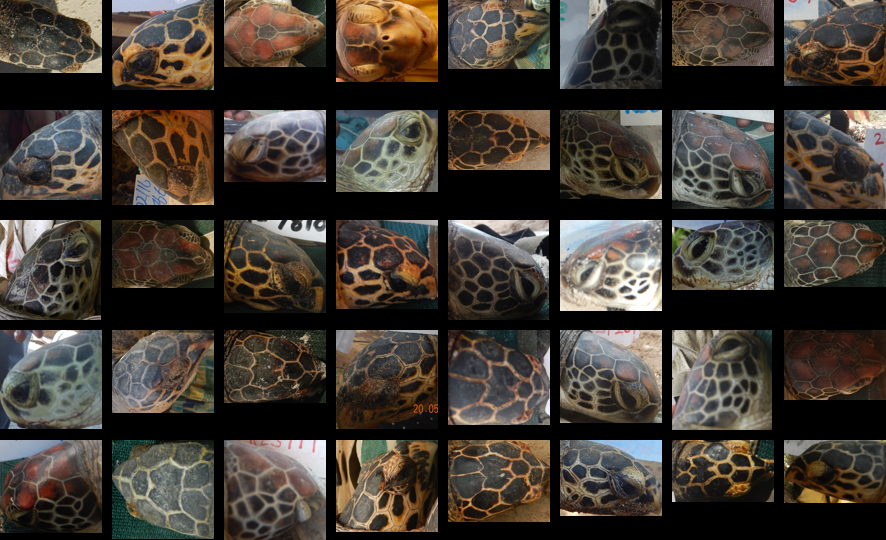

In [5]:
analysis.plot_grid(df.loc[idx_test2], '')

Finally, we show some difference between these two splits. The numerical comparison will be probably a bit skewed because the second testing set contains much more individuals (2265) than the first testing set (203). The training set is the same in both cases (197 individuals).

In [6]:
splits.analyze_split(df, idx_train, idx_test1)

Split: time-unaware disjoint-set
Samples: train/test/unassigned/total = 3820/3762/12803/20385
Classes: train/test/unassigned/total = 197/203/2265/2665
Classes: train only/test only/joint  = 197/203/0

Fraction of train set     = 50.38%
Fraction of test set only = 49.62%


In [7]:
splits.analyze_split(df, idx_train, idx_test2)

Split: time-unaware disjoint-set
Samples: train/test/unassigned/total = 3820/12803/3762/20385
Classes: train/test/unassigned/total = 197/2265/203/2665
Classes: train only/test only/joint  = 197/2265/0

Fraction of train set     = 22.98%
Fraction of test set only = 77.02%


To access the training (or testing) set, we just retrieve the relevant indices in the dataframe. The column `identity` shows the identity (label) of the animal depicted at the image stored in the column `path`.

In [8]:
df.loc[idx_train]

,id,identity,path
35,35,t182,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
36,36,t182,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
37,37,t182,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
38,38,t182,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
39,39,t182,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
...,...,...,...
7577,7769,t157,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
7578,7770,t157,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
7579,7771,t157,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
7580,7772,t157,/mnt/data/turtles/datasets/datasets/SeaTurtleI...
